### Basic test of classification with the new features

##### Here we investiage whether adding more features is helpful. We find that there is probably an optimal number of features to train on
##### which implies that we should do PCA

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [4]:
import DataProcess as DP
import glob
import time
import pandas as pd
from plotting_tools import plot_feature_distributions
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
protocol_datadir = '/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/'
optional_datadir = '/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Optional/'

In [6]:
allfiles = list(glob.glob(protocol_datadir+'*.dat'))+list(glob.glob(optional_datadir+'*.dat'))

all_dfs = []
for fname in allfiles:
    print(fname)
    dp = DP.dataprocess(fname,T=512,stride=512)
    all_dfs.append(dp.df)
    
feature_df = pd.concat(all_dfs)

/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject101.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject102.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject103.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject104.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject105.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject106.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject107.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject108.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject109.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Optional/subject101.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2

In [95]:
feature_df.to_csv('Features_test.dat',index=False)

### Figure out the number of segments associated with each activity

In [90]:
activity_dict={0:'other',1:'lying',2:'sitting',3:'standing',4:'walking',5:'running',6:'cycling',7:'nordic walking',
              9:'watching TV',10:'computer work',11:'car driving',12:'ascending stairs',13:'descending stairs',
              16:'vacuum cleaning',17:'ironing',18:'folding laundry',19:'house cleaning',20:'playing_soccer',
              24:'rope jumping'}

activities = feature_df['activityID'].unique()
activity_list = [activity_dict[i] for i in activities]
len_activities = []
for activityID in activities:
    len_activities.append(len(feature_df[feature_df['activityID'] == activityID]))

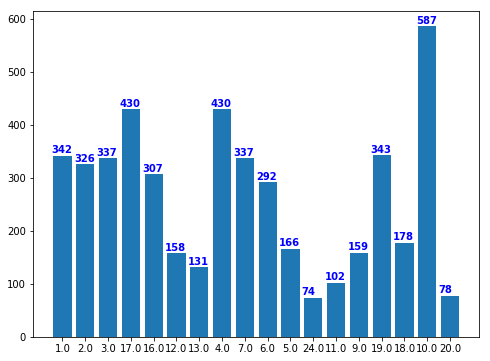

In [94]:
plt.figure(figsize=(8,6))
plt.bar(range(len(alist)),len_activities,tick_label=activities)

xoffset = -0.5
for i in range(len(len_activities)):
    plt.text(xoffset, len_activities[i]+5, str(len_activities[i]), color='blue', fontweight='bold')
    xoffset += 1
    
#plt.setp(labels, rotation=90)

    
#plt.grid()
plt.show()

In [119]:
activity_list = ['lying','sitting','standing','walking','running','cycling','nordic walking','watching TV',
                 'computer work','car driving','ascending stairs','descending stairs',
                  'vacuum cleaning','ironing','folding laundry','house cleaning','playing_soccer','rope jumping']
#activities = pd.get_dummies(feature_df['activityID'],drop_first=True)
activities = feature_df['activityID']
activities = feature_df['activityID'].astype("category")

In [120]:
activities.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: activityID, dtype: category
Categories (18, float64): [1.0, 2.0, 3.0, 4.0, ..., 18.0, 19.0, 20.0, 24.0]

In [121]:
X = feature_df.drop(['activityID'],axis=1)

#### Train a random forest and looking at the feature importances

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X,activities,test_size=0.3)

In [123]:
RF = RandomForestClassifier(n_estimators=50,min_samples_split=2,min_samples_leaf=1,max_depth=12,oob_score=True)
#note the max_features criterion here - setting this between 50 and 100 makes a small improvment to the results 

In [124]:
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [125]:
RF.oob_score_

0.9739754711337122

In [126]:
#list the most important features and their importance values
importances = RF.feature_importances_
args = np.flip(np.argsort(importances),axis=0)

In [127]:
features_to_keep = []
for i in range(10):
    arg = args[i]
    print('Feature %s. Importance: %f' %(X_train.columns[arg],importances[arg]))
    features_to_keep.append(X_train.columns[arg])

Feature hand_acc16g_x_median. Importance: 0.022401
Feature chest_acc16g_y_peak. Importance: 0.020967
Feature ankle_acc16g_x_std. Importance: 0.019611
Feature hand_acc16g_y_kurtosis. Importance: 0.018852
Feature ankle_gyro_z_std. Importance: 0.018012
Feature chest_acc16g_x_std. Importance: 0.017492
Feature chest_mag_y_mean. Importance: 0.017091
Feature chest_acc16g_z_mean. Importance: 0.017084
Feature chest_gyro_y_std. Importance: 0.016938
Feature hand_acc16g_x_mean. Importance: 0.016546


In [128]:
RF.score(X_test,y_test)

0.9783821478382148

Interestingly we seem to be doing worse with all these features. This suggests that we might be overfitting and need to reduce the number of features. Lets try to see if there is an optimal number of features for our test score

In [129]:
def investigate_feature_numbers(X,Y,classifier,step_features=5,min_features=3):
    
    '''
    Train the algorithm on datasets containing decreasing numbers of features in order to
    determine if there is an optimal number of features
    '''
    
    #Start by training a random forest
    
    print("Training on all features")
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)
    classifier.fit(X_train,y_train)
    
    train_scores = [classifier.oob_score_]
    test_scores  = [classifier.score(X_test,y_test)]
    feature_number_list = [len(X_train.columns)]
    
    #Extract just the first n features to train on. We'll extract the features in order of importance
    #to try to ensure that we get 
    
    importances = RF.feature_importances_
    args = np.flip(np.argsort(importances),axis=0)
    features_to_keep = []
    for i in range(len(X_train.columns)-step_features):
        arg = args[i]
        features_to_keep.append(X_train.columns[arg])
        
    for feature_number in np.arange(len(X.columns)-step_features,min_features,-step_features):
         
        X_new = X[features_to_keep]
        
        print("Training on %i features" %feature_number)
        
        X_train, X_test, y_train, y_test = train_test_split(X_new,Y,test_size=0.3)
        classifier.fit(X_train,y_train)
        train_scores.append(classifier.oob_score_)
        test_scores.append(classifier.score(X_test,y_test))
        feature_number_list.append(len(X_new.columns))
        
        importances = classifier.feature_importances_
        args = np.flip(np.argsort(importances),axis=0)
        features_to_keep = []
        for i in range(feature_number-step_features):
            arg = args[i]
            features_to_keep.append(X_train.columns[arg])
            
        if len(features_to_keep) < min_features:
            return test_scores, train_scores, feature_number_list
        
        

In [130]:
test_scores, train_scores, feature_numbers = investigate_feature_numbers(X,activities,RF)

Training on all features
Training on 192 features
Training on 187 features
Training on 182 features
Training on 177 features
Training on 172 features
Training on 167 features
Training on 162 features
Training on 157 features
Training on 152 features
Training on 147 features
Training on 142 features
Training on 137 features
Training on 132 features
Training on 127 features
Training on 122 features
Training on 117 features
Training on 112 features
Training on 107 features
Training on 102 features
Training on 97 features
Training on 92 features
Training on 87 features
Training on 82 features
Training on 77 features
Training on 72 features
Training on 67 features
Training on 62 features
Training on 57 features
Training on 52 features
Training on 47 features
Training on 42 features
Training on 37 features
Training on 32 features
Training on 27 features
Training on 22 features
Training on 17 features
Training on 12 features
Training on 7 features


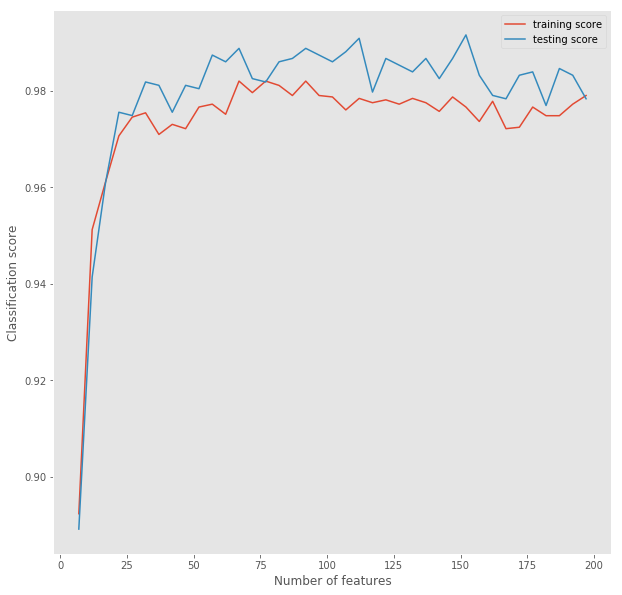

In [131]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10,10))
plt.plot(feature_numbers,train_scores,label='training score')
plt.plot(feature_numbers,test_scores,label='testing score')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Classification score')
plt.grid(axis='both')

#### Since it seems like ~75 features is optimal, lets try a PCA here

In [178]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


##### We can choose to scale the input data, but it does not make a dramatic change to the results

In [179]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

##### Use PCA to transform the data

In [223]:
pca = PCA(n_components=9)
pca.fit(X)
X_pca = pca.transform(X)

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X_pca,activities,test_size=0.3)
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [225]:
RF.oob_score_

0.9861167320652461

In [226]:
RF.score(X_test,y_test)

0.8172942817294282

#### Its quite odd that the RF performs well on a PCA dataset with only a small number of components. Increasing the number of components reduces the fit

In [2]:
feature_df['activityID'].unique()

NameError: name 'feature_df' is not defined